# Generating trajectories using quantum state diffusion.

The purpose of this notebook is to generate data that could be analyzed using machine learning algorithms. I use quantum state diffusion (as opposed to quantum jump trajectories) to investigate how the dynamics and geometry might be different. The files are saved in the same format as the notebooks my other repo, diffusion_maps: https://github.com/tabakg/diffusion_maps

1. Kerr in qubit regime
2. Kerr in bistable regime
3. Atom bistability (see notebook "make_quantum_trajectories-absorptive_bistability").

We will also be interested in the transition between the first and second regimes of the Kerr system.
I store trajectory files as .pkl files or .mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

In [2]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [3]:
####
####

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"
### TODO: implement a regime "transition_kerr" which increases the drive periodically, or stochastically, etc.

Regime = "kerr_bistable"
file_name = './trajectory_data/QSD_' + Regime

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True

## pkl file (can be loaded in python) in the same format as above.
save_pkl = True

####
####

In [4]:
import matplotlib as mil
mil.use('TkAgg')

In [5]:
## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace
from sympy import sqrt

## SDE integrator
import sdeint

## quantum state diffusion solver
from quantum_state_diffusion import qsd_solve

## numerical libraries
import numpy as np
import numpy.linalg as la
from scipy import sparse

## plottinsg
import matplotlib.pyplot as plt

## pickle
import pickle

In [6]:
from save2matfile_or_pkl import save2matfile_or_pkl

In [7]:
%matplotlib inline

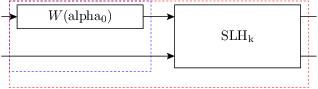

In [8]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

if Regime == "kerr_bistable":
    ## bistable regime
    params = {alpha0 : 52.467, chi : -106.066, Delta : 750., kappa_1 : 220., kappa_2 : 0,
              'Ntraj' : 200, 'duration' : 100., 'Nfock' : 15, 'delta_t': 1e-4, 'downsample': 100}
elif Regime == "kerr_qubit":
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 15000., 'Nfock' : 15, 'delta_t': 2e-5, 'downsample': 100}
# elif Regime == "intermediate_state":
#     params = {alpha0 : 100.0, chi : -20.0, Delta : 0, kappa_1 : 1., kappa_2 : 0,
#               'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}
else:
    raise ValueError("Unknown regime, or not implemented yet.")
    
## These are used later in the simulation
ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']
delta_t = params['delta_t']
downsample = params['downsample']

# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
tspan = np.arange(0, duration*1e-3, delta_t)

H_num, L_num = SYS_num.HL_to_qutip()

## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

In [9]:
psi0 = sparse.csr_matrix(([1] + [0]*(Nfock-1)),dtype=np.complex128).T
H = H_num.data
Ls = [L.data for L in L_num]
obsq = [ob.data for ob in obsq]


# Kerr Bistable Regime

In [10]:
Regime = "kerr_bistable"
file_name = './trajectory_data/QSD_' + Regime

In [11]:
seed = [i for i in range(ntraj)]

In [12]:
H, psi0, tspan, Ls, sdeint.itoSRI2, obsq, ntraj

(<15x15 sparse matrix of type '<class 'numpy.complex128'>'
 	with 42 stored elements in Compressed Sparse Row format>,
 <15x1 sparse matrix of type '<class 'numpy.complex128'>'
 	with 1 stored elements in Compressed Sparse Column format>,
 array([ 0.    ,  0.0001,  0.0002,  0.0003,  0.0004,  0.0005,  0.0006,
         0.0007,  0.0008,  0.0009,  0.001 ,  0.0011,  0.0012,  0.0013,
         0.0014,  0.0015,  0.0016,  0.0017,  0.0018,  0.0019,  0.002 ,
         0.0021,  0.0022,  0.0023,  0.0024,  0.0025,  0.0026,  0.0027,
         0.0028,  0.0029,  0.003 ,  0.0031,  0.0032,  0.0033,  0.0034,
         0.0035,  0.0036,  0.0037,  0.0038,  0.0039,  0.004 ,  0.0041,
         0.0042,  0.0043,  0.0044,  0.0045,  0.0046,  0.0047,  0.0048,
         0.0049,  0.005 ,  0.0051,  0.0052,  0.0053,  0.0054,  0.0055,
         0.0056,  0.0057,  0.0058,  0.0059,  0.006 ,  0.0061,  0.0062,
         0.0063,  0.0064,  0.0065,  0.0066,  0.0067,  0.0068,  0.0069,
         0.007 ,  0.0071,  0.0072,  0.0073,  0.0074

In [80]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoSRI2, obsq = obsq, ntraj = ntraj, seed = seed, normalize_state = True)

Run time:   55.22324204444885  seconds.


In [81]:
D.update({'tspan':tspan})
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

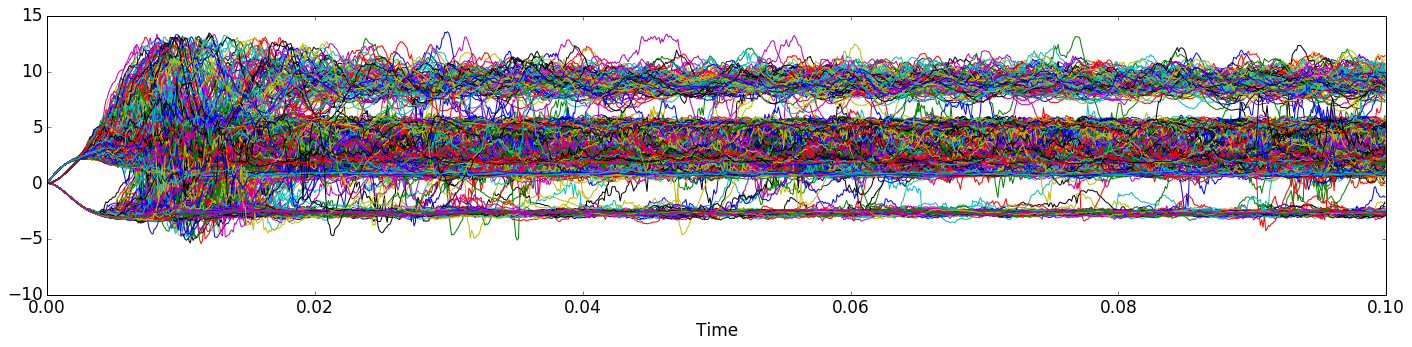

In [82]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    for i in range(3):
        plt.plot(tspan,D['obsq_expects'][t,:,i].real)

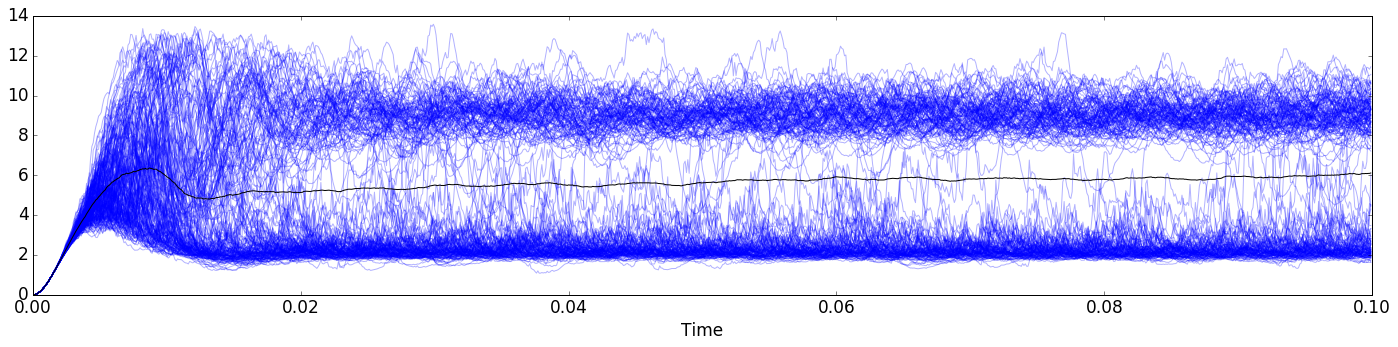

In [83]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,0].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


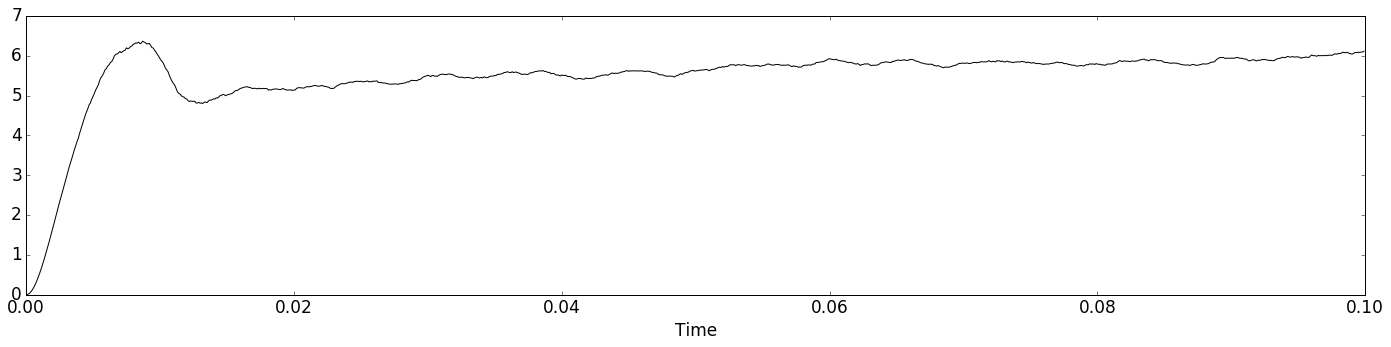

In [84]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )

In [86]:
D['psis'].shape

(200, 1000, 15)

In [87]:
save2matfile_or_pkl(D, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_bistable.mat

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_bistable.pkl

{'expects': array([[[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  6.03449194e-03 +0.00000000e+00j,
            1.55252202e-01 +4.33680869e-19j,
           -5.78356638e-03 +0.00000000e+00j],
         [  2.36267173e-02 +0.00000000e+00j,
            3.06224094e-01 +1.73472348e-18j,
           -2.43734167e-02 -2.77521875e-17j],
         ..., 
         [  9.28630183e+00 +0.00000000e+00j,
            2.97913434e+00 +0.00000000e+00j,
            4.30774965e+00 -1.66533454e-16j],
         [  9.50506735e+00 +1.11022302e-16j,
            2.60116280e+00 +5.55111512e-17j,
            4.63290976e+00 +1.11022302e-16j],
         [  9.44185070e+00 +8.32667268e-17j,
            2.64341710e+00 -1.66533454e-16j,
            4.93824161e+00 +2.77555756e-17j]],
 
        [[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  6.03449

# Kerr Qubit Regime

In [93]:
Regime = "kerr_qubit"
file_name = './trajectory_data/QSD_' + Regime

In [94]:
seed = [i for i in range(ntraj)]

In [96]:
D = qsd_solve(H, psi0, tspan, Ls, sdeint.itoSRI2, obsq = obsq, ntraj = ntraj, seed = seed, normalize_state = True)

Run time:   2762.5639820098877  seconds.


In [97]:
D.update({'tspan':tspan})
D_downsampled = {'psis' : D['psis'][:,::downsample],
                 'obsq_expects' : D['obsq_expects'][:,::downsample], 
                 'seeds' : D['seeds'],
                 'tspan' : D['tspan'] }

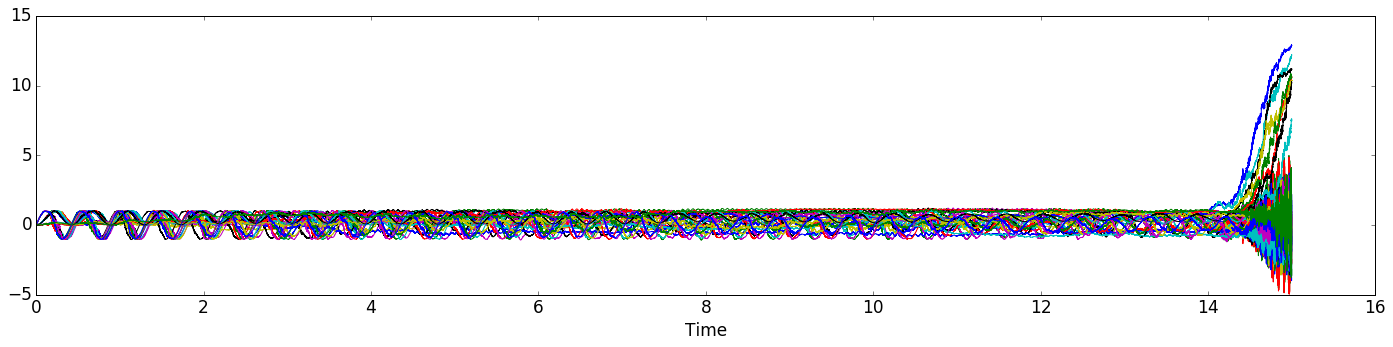

In [98]:
## Plot the observables
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

for t in range(ntraj):
    for i in range(3):
        plt.plot(tspan,D['obsq_expects'][t,:,i].real)

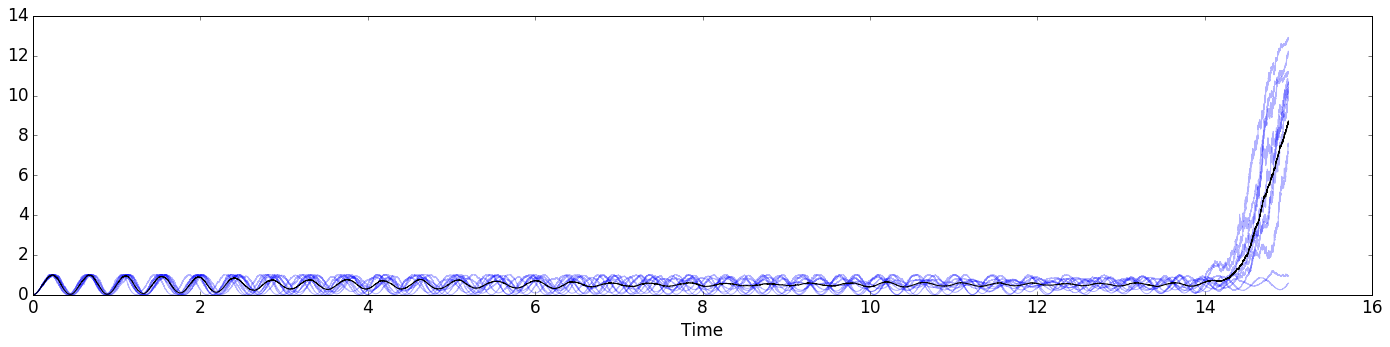

In [99]:
f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for t in range(ntraj): 
    a.plot( tspan, D['obsq_expects'][t,:,0].real , "b", alpha=0.3)

a.plot(tspan,
       np.average( np.asarray( [D['obsq_expects'][t,:,0].real for t in range(ntraj) ] ), axis = 0),
       c='black',
      )


In [100]:
save2matfile_or_pkl(D_downsampled, file_name, obs, params = {}, save_mat = save_mat, save_pkl = save_pkl)

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_qubit.mat

/Users/gil/Documents/repos/SDEs/trajectory_data/QSD_kerr_qubit.pkl

{'expects': array([[[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  1.99899976e-04 +1.15910924e-69j,
            2.82771850e-02 +5.29395592e-23j,
           -1.11239977e-07 -1.73472348e-18j],
         [  7.99212516e-04 +0.00000000e+00j,
            5.65402946e-02 -6.73637541e-46j,
            5.57620193e-06 +3.46944706e-18j],
         ..., 
         [  1.27875431e+01 +4.85722573e-17j,
           -3.12222551e+00 +3.88578059e-16j,
           -4.14639787e-01 -2.77555756e-17j],
         [  1.28693358e+01 +2.22044605e-16j,
            2.86105363e+00 +1.38777878e-16j,
           -7.54815324e-01 -8.32667268e-17j],
         [  1.28870552e+01 +4.44089210e-16j,
           -1.82594502e+00 -1.66533454e-16j,
            1.87398434e+00 +2.63677968e-16j]],
 
        [[  0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j,
            0.00000000e+00 +0.00000000e+00j],
         [  1.99899